In [1730]:
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm
from scipy.stats import multivariate_normal

In [1731]:
data = pd.read_csv('./data/leukemia_big.csv')
data.shape

(7128, 72)

In [1732]:
np.random.seed(1234)

In [1733]:
ALL_columns = [c for c in data.columns if 'ALL' in c]
AML_columns = [c for c in data.columns if 'AML' in c]
ttest_df = pd.DataFrame(columns=['sampleId','ttest'])
for i in tqdm(data.index):
    pvlaue = scipy.stats.ttest_ind(data.T.loc[ALL_columns,i], data.T.loc[AML_columns,i]).pvalue
    ttest_df = ttest_df.append({'sampleId':str(i),'ttest':pvlaue}, ignore_index=True)

100%|██████████| 7128/7128 [00:31<00:00, 227.50it/s]


In [1734]:
select100 = ttest_df.sort_values('ttest').iloc[:100].index

In [1735]:
X = data.iloc[select100].values
mean_x = np.mean(X, axis=1, keepdims=True)
X_center = X - mean_x

In [1501]:
class MFA:
    def __init__(self, X, n_cluster, n_factor):
        mean_x = np.mean(X, axis=1, keepdims=True)
        self.X = X - mean_x
        self.D, self.N = X.shape
        # set hyper parameter
        '''
        n_factor : The number of latent value (q)
        n_cluster : The number of cluster
        '''
        self.n_factor = n_factor
        self.n_cluster = n_cluster
        # E_step parameter
        self.Es = None
        self.Ess = None
        self.Rjt = None
        # M_step parameter
        self.pi = None
        self.mu = None
        self.A = None
        self.sigma = None
        # complete log-likelihood 
        self.cll = list()
        
    def _initializer(self):
        self.pi = np.array([1] * self.n_cluster) / self.n_cluster  # (K,) array
        self.mu = np.random.normal(0, 0.1, size=self.n_cluster*self.D*1).reshape(self.n_cluster, self.D, 1)
        self.A = np.random.normal(size=self.n_cluster*self.D*self.n_factor).reshape(self.n_cluster, self.D, self.n_factor)
        self.sigma = np.diag(np.ones(shape=self.D))
    
    def is_pos_def(self, x):
        return np.all(np.linalg.eigvals(x) > 0)

    def make_psd(self, cov_Xt):
        if self.is_pos_def(cov_Xt) != True:
            cov_Xt = cov_Xt + 10*abs(float(min(np.linalg.eigvals(cov_Xt)).real))*np.eye(self.D)
        return cov_Xt
    
    def E_step(self):
        cov_Xt = lambda j:np.matmul(self.A[j,:], self.A[j,:].T) + self.sigma  #AjAj^T + sigma
        gaussian_pdf = np.array([multivariate_normal.pdf(self.X.T, self.mu[j].flatten(), self.make_psd(cov_Xt(j)), allow_singular=True) \
                                 for j in range(self.n_cluster)])

        pdf_weight = gaussian_pdf.sum()
        print('pdf sum : ', pdf_weight)
#         print('pdf sum logic : ', pdf_weight < 1e-47)
        
#         if pdf_weight < 1e-47:
#             gaussian_pdf = 100 * gaussian_pdf
#             pdf_weight2 = (gaussian_pdf).sum()
#             print('pdf weights2 : ', pdf_weight2)

        Rjt = self.pi.reshape(-1,1) * gaussian_pdf
        Rjt = Rjt/Rjt.sum(axis=0, keepdims=True)
        Es, Ess = list(), list()
        for j in range(self.n_cluster):
            phi = np.matmul(self.A[j].T, np.linalg.inv(self.make_psd(cov_Xt(j)))) # pi
            Esj, Essj = list(), list()
            for t in range(self.N):
                Esjt = phi @ (self.X[:,t] - self.mu[j].flatten())
                Essjt = np.eye(self.n_factor) - (phi @ self.A[j]) + phi @ (self.X[:,t] - self.mu[j]) @ (self.X[:,t] - self.mu[j]).T @ phi.T
                Esj.append(Esjt)
                Essj.append(Essjt)
            Es.append(Esj)
            Ess.append(Essj)
        self.Es, self.Ess, self.Rjt =  np.array(Es), np.array(Ess), Rjt
    
    def M_step(self): 
        A_new = np.zeros(shape=(self.n_cluster, self.D, self.n_factor))
        for j in range(self.n_cluster):
            temp_Aj = np.zeros(shape=(self.D, self.n_factor))
            for t in range(self.N):
                temp_Aj += self.Rjt[j,t]*((self.X[:,t].reshape(-1,1) - self.mu[j]) @ self.Es[j,t].reshape(1,-1)) @ self.Ess[j,t]
            A_new[j,:,:] = temp_Aj
        mu_new = np.zeros(shape=(self.D, self.n_cluster))
        sigma_new = np.zeros(shape=(self.D, self.D))
        for j in range(self.n_cluster):
            temp_muj = np.zeros(shape=(self.D, 1))
            denominator = 0
            for t in range(self.N):
                temp_muj += self.Rjt[j,t]*((self.X[:,t].reshape(-1,1) - A_new[j,:,:] @ self.Es[j,t].reshape(-1,1)))
                sigma_new += self.Rjt[j,t]*((self.X[:,t].reshape(-1,1) - self.mu[j]) @ (self.X[:,t].reshape(-1,1) - self.mu[j]).T - (A_new[j,:,:] @ self.Es[j,t].reshape(-1,1) @ (self.X[:,t].reshape(-1,1) - self.mu[j]).T))
                denominator += self.Rjt[j,t]

            mu_new[:,j] = (temp_muj/denominator).flatten()

        sigma_new = (1/self.N)*np.diag(np.diag(sigma_new))
        pi_new = self.Rjt.mean(axis=1)
        self.A, self.mu, self.sigma, self.pi =  A_new, mu_new.T.reshape(self.n_cluster,100,1), sigma_new, pi_new
    
#     def loss_func(self):
#         cll = -0.5*self.*np.log(np.linalg.det(self.sigma))

In [1502]:
mfa = MFA(X_center, 4, 3)

In [1503]:
mfa._initializer()

In [1504]:
mfa.E_step()
mfa.M_step()

pdf sum :  1.7973902824565e-46


In [1505]:
-(0.5*mfa.Rjt*np.log(np.linalg.det(mfa.sigma))).sum()

4981.589645150569

In [1506]:
mfa.sigma

array([[0.61438558, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.74349534, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.22703215, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.23809098, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14154684,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.13866806]])

In [1507]:
mfa.mu.shape

(4, 100, 1)

In [1508]:
mfa.pi.shape

(4,)

In [1509]:
mfa.mu.shape

(4, 100, 1)

In [662]:
mfa.A

array([[[-1.00280534e+04,  1.02387258e+03, -1.90565382e+04],
        [ 4.59889400e+03, -4.69550690e+02,  8.73938322e+03],
        [-8.45832857e+02,  8.63602814e+01, -1.60735537e+03],
        ...,
        [ 4.06676247e+03, -4.15219810e+02,  7.72816129e+03],
        [-1.79789558e+03,  1.83566584e+02, -3.41658195e+03],
        [ 7.25996172e+03, -7.41248069e+02,  1.37962706e+04]],

       [[-9.15069117e+06,  9.72636282e+06, -1.05828864e+07],
        [-1.73954489e+07,  1.84897998e+07, -2.01180497e+07],
        [-5.46360088e+06,  5.80731701e+06, -6.31872131e+06],
        ...,
        [ 2.65419381e+06, -2.82116963e+06,  3.06960763e+06],
        [ 3.87644631e+06, -4.12031425e+06,  4.48315761e+06],
        [ 1.91610422e+06, -2.03664669e+06,  2.21599799e+06]],

       [[-2.88458417e+03,  2.13036821e+03,  4.09418420e+03],
        [-2.62306151e+03,  1.93725223e+03,  3.72301609e+03],
        [-7.90461467e+02,  5.83791853e+02,  1.12193322e+03],
        ...,
        [ 3.58460589e+03, -2.64734075e+03,

In [663]:
mfa.pi

array([0.00822865, 0.01291479, 0.07695805, 0.9018985 ])

In [665]:
mfa.Rjt[:,10]

array([0.00822302, 0.01291604, 0.07690588, 0.90195507])

In [1729]:
class MFA:
    def __init__(self, X, n_cluster, n_factor):
        mean_x = np.mean(X, axis=1, keepdims=True)
        self.X = X - mean_x
        self.D, self.N = X.shape
        # set hyper parameter
        '''
        n_factor : The number of latent value (q)
        n_cluster : The number of cluster
        '''
        self.n_factor = n_factor
        self.n_cluster = n_cluster
        # E_step parameter
        self.Es = None
        self.Ess = None
        self.Rjt = None
        # M_step parameter
        self.pi = None
        self.mu = None
        self.A = None
        self.sigma = None
        # complete log-likelihood 
        self.cll = [inf]
        
    def _initializer(self):
        self.pi = np.array([1] * self.n_cluster) / self.n_cluster  # (K,) array
        self.mu = np.random.normal(0, 0.1, size=self.n_cluster*self.D*1).reshape(self.n_cluster, self.D, 1)
        self.A = np.random.normal(size=self.n_cluster*self.D*self.n_factor).reshape(self.n_cluster, self.D, self.n_factor)
        self.sigma = np.diag(np.ones(shape=self.D))
    
    def is_pos_def(self, x):
        return np.all(np.linalg.eigvals(x) > 0)

    def make_psd(self, cov_Xt):
        if self.is_pos_def(cov_Xt) != True:
            cov_Xt = cov_Xt + 10*abs(float(min(np.linalg.eigvals(cov_Xt)).real))*np.eye(self.D)
        return cov_Xt
    
    def E_step(self):
        cov_Xt = lambda j:np.matmul(self.A[j,:], self.A[j,:].T) + self.sigma  #AjAj^T + sigma
        gaussian_pdf = np.array([multivariate_normal.pdf(self.X.T, self.mu[j].flatten(), self.make_psd(cov_Xt(j)), allow_singular=True) \
                                 for j in range(self.n_cluster)])

        pdf_weight = gaussian_pdf.sum()
        print('pdf sum : ', pdf_weight)
#         print('pdf sum logic : ', pdf_weight < 1e-47)
        
#         if pdf_weight < 1e-47:
#             gaussian_pdf = 100 * gaussian_pdf
#             pdf_weight2 = (gaussian_pdf).sum()
#             print('pdf weights2 : ', pdf_weight2)

        Rjt = self.pi.reshape(-1,1) * gaussian_pdf
        Rjt = Rjt/Rjt.sum(axis=0, keepdims=True)
        Es, Ess = list(), list()
        for j in range(self.n_cluster):
            phi = np.matmul(self.A[j].T, np.linalg.inv(self.make_psd(cov_Xt(j)))) # pi
            Esj, Essj = list(), list()
            for t in range(self.N):
                Esjt = phi @ (self.X[:,t] - self.mu[j].flatten())
                Essjt = np.eye(self.n_factor) - (phi @ self.A[j]) + phi @ (self.X[:,t] - self.mu[j]) @ (self.X[:,t] - self.mu[j]).T @ phi.T
                Esj.append(Esjt)
                Essj.append(Essjt)
            Es.append(Esj)
            Ess.append(Essj)
        self.Es, self.Ess, self.Rjt =  np.array(Es), np.array(Ess), Rjt
    
    def M_step(self): 
        A_new = np.zeros(shape=(self.n_cluster, self.D, self.n_factor))
        for j in range(self.n_cluster):
            Aj1 = np.zeros(shape=(self.D, self.n_factor))
            Aj2 = np.zeros(shape=(self.n_factor, self.n_factor))
            for t in range(self.N):
                Aj1 += self.Rjt[j,t] * ((self.X[:,t].reshape(-1,1) - self.mu[j]) @ self.Es[j,t].reshape(1,-1))
                Aj2 += self.Rjt[j,t] * self.Ess[j,t]
            A_new[j,:,:] = Aj1 @ np.linalg.inv(Aj2)
        mu_new = np.zeros(shape=(self.D, self.n_cluster))
        sigma_new = np.zeros(shape=(self.D, self.D))
        for j in range(self.n_cluster):
            temp_muj = np.zeros(shape=(self.D, 1))
            denominator = 0
            for t in range(self.N):
                temp_muj += self.Rjt[j,t]*((self.X[:,t].reshape(-1,1) - A_new[j,:,:] @ self.Es[j,t].reshape(-1,1)))
                sigma_new += self.Rjt[j,t]*((self.X[:,t].reshape(-1,1) - self.mu[j]) @ (self.X[:,t].reshape(-1,1) - self.mu[j]).T - (A_new[j,:,:] @ self.Es[j,t].reshape(-1,1) @ (self.X[:,t].reshape(-1,1) - self.mu[j]).T))
                denominator += self.Rjt[j,t]

            mu_new[:,j] = (temp_muj/denominator).flatten()

        sigma_new = (1/self.N)*np.diag(np.diag(sigma_new))
        pi_new = self.Rjt.mean(axis=1)
        self.A, self.mu, self.sigma, self.pi =  A_new, mu_new.T.reshape(self.n_cluster,100,1), sigma_new, pi_new
    
#     def loss_func(self):
# #         const = (-0.5 * self.Rjt * np.log(np.linalg.det(self.sigma))).sum()
#         exp_term = 0
#         inv_sigma = np.linalg.inv(self.sigma)
#         for j in range(self.n_cluster):
#             for t in range(self.N):
#                 temp_exp_term = self.X[:,t].reshape(-1,1) - (self.A[j,:,:] @ self.Es[j,t,:].reshape(-1,1)) - self.mu[j,:,:]
# #                 print(temp_exp_term.shape)
#                 exp_term += -1 * self.Rjt[j,t] * (temp_exp_term.T @ inv_sigma @ temp_exp_term)
#         print("completed log-likelihood : ", exp_term[0][0])
#         self.cll.append(exp_term[0][0])

    def loss_function(self):
        self.loss = 0
        inv_sigma = np.linalg.inv(self.sigma)
        for j in range(self.n_cluster):
            for t in range(self.N):
                loss_temp = np.log(self.pi[j]) - 0.5*(self.X[:, t] @ inv_sigma @ self.X[:, t] - 2 * self.X[:, t] @ inv_sigma @ self.A[j] @ self.Es[j, t] \
                                              -2 * self.X[:,t] @ inv_sigma @ self.mu[j].reshape(-1) + 2 * mfa.mu[j].reshape(-1) @ inv_sigma @ self.A[j]@ self.Es[j,t]\
                                              + np.matrix.trace(self.A[j].T @ inv_sigma @ self.A[j] @ self.Ess[j,t]) + self.mu[j].reshape(-1) @ inv_sigma @self.mu[j].reshape(-1))      
#                 loss = self.Rjt[j,t]*(loss_temp - np.log(np.linalg.det(self.sigma))-(self.D/2)*np.log(2*np.pi))
                det_sigma = np.linalg.det(self.sigma)
                if det_sigma < 1e-90:
                    det_sigma + np.exp(-210)
                else:
                    pass                    
                loss = self.Rjt[j,t]*(loss_temp - 0.5 * np.log(det_sigma) - (self.D/2)*np.log(2*np.pi))
                self.loss += loss
        print("completed log-likelihood : ", self.loss)
        self.cll.append(self.loss)
    
    def fit(max_iter=20, tol_el=1e-2):
        iter_ = 0
        while iter_ < max_iter:
            self.E_step()
            self.M_step()
            self.loss_function()
            if abs(self.cll[-1] - self.loss) < 1e-2:
                print("old_loss : ", self.cll[-1])
                print("new_loss : ", self.loss)
                break
            iter_ += 1

In [1717]:
mfa = MFA(X_center, n_cluster=2, n_factor=3)

In [1718]:
mfa._initializer()

In [1725]:
mfa.loss

-3125.134806486603

In [1720]:
for iter in range(30):
    mfa.E_step()
    mfa.M_step()
    mfa.loss_function()

pdf sum :  1.4148079100883764e-46
completed log-likelihood :  -4917.288514134908
pdf sum :  2.673929454723997e-16
completed log-likelihood :  -4049.935911126402
pdf sum :  3.786457361655136e-12
completed log-likelihood :  -4725.465013671034
pdf sum :  4.0911036327928685e-14
completed log-likelihood :  -3538.282803424109
pdf sum :  6.233809056192657e-11
completed log-likelihood :  -3216.987101996523
pdf sum :  1.7520116402963872e-08
completed log-likelihood :  -3176.039978528011
pdf sum :  1.625038500687247e-08
completed log-likelihood :  -3134.097372687071
pdf sum :  2.658201825391531e-08
completed log-likelihood :  -3116.1235150484936
pdf sum :  5.363226251182362e-08
completed log-likelihood :  -3127.6404628953906
pdf sum :  2.782962450464321e-08
completed log-likelihood :  -3129.423605506459
pdf sum :  2.4103855152922626e-08
completed log-likelihood :  -3125.164287863781
pdf sum :  3.644575025888788e-08
completed log-likelihood :  -3123.006410968732
pdf sum :  4.1764333209324016e-08


In [1721]:
# for iter in range(20):
#     mfa.E_step()
#     mfa.M_step()
#     mfa.loss_func()

In [1722]:
import matplotlib.pyplot as plt

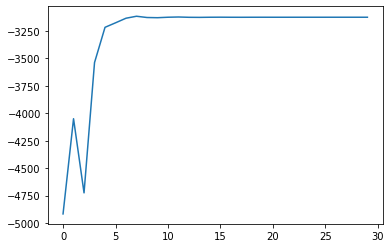

In [1723]:
plt.plot(mfa.cll)

In [1724]:
mfa.Rjt

array([[3.22066971e-103, 8.69217748e-058, 3.13405818e-076,
        5.50002167e-053, 1.45225098e-117, 9.47735875e-091,
        7.20897353e-117, 1.51085513e-082, 5.30413778e-132,
        4.68323742e-097, 3.21306696e-109, 7.71907012e-090,
        1.83931316e-073, 5.43938883e-093, 9.56389895e-092,
        4.56117731e-098, 3.77309522e-017, 3.33871276e-053,
        1.60325725e-090, 4.01267685e-069, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
        1.85383352e-017, 1.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 7.04698627e-115, 1.55626569e-036,
        8.32416258e-092, 7.63137198e-096, 1.14452707e-075,
        1.25831381e-076, 1.69105199e-082, 4.76905529e-107,
        1.23337972e-090, 2.28409850e-058, 2.95667492e-095,
        1.97458467e-016, 1.98356888e-122, 3.34115269e-048,
        1.10757298e-114, 2.03422798e-122, 8.04600272e-03